In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


twitch_df = pd.read_csv("Twitch_game_data.csv", encoding='latin-1')
igdb_df = pd.read_csv("igdb_data.csv", encoding='UTF-8')

merged_df = pd.merge(twitch_df, igdb_df, on='Game', how='left')
merged_df.dropna(subset=['Rank', 'Release Year', 'Genre'], inplace=True)
merged_df = pd.get_dummies(merged_df, columns=['Genre'], dummy_na=True)

features = ['Hours_watched', 'Avg_viewers', 'Hours_streamed', 'Peak_viewers', 'Streamers'] \
           + [col for col in merged_df.columns if col.startswith('Genre_')]

target = 'Rank'

X = merged_df[features]
y = merged_df[target]

print(X.head())


   Hours_watched  Avg_viewers  Hours_streamed  Peak_viewers  Streamers  \
0       94377226       127021         1362044        530270     129172   
1       47832863        64378          830105        372654     120849   
2       45185893        60815          433397        315083      44074   
3       39936159        53749          235903        131357      36170   
4       16153057        21740         1151578         71639     214054   

   Genre_Adventure  Genre_Adventure, Indie  Genre_Adventure, Indie, Arcade  \
0            False                   False                           False   
1            False                   False                           False   
2            False                   False                           False   
3            False                   False                           False   
4            False                   False                           False   

   Genre_Adventure, Indie, Visual Novel  Genre_Adventure, Visual Novel  ...  \
0      

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf_regressor = RandomForestRegressor(
    n_estimators=100,      
    max_depth=10,           
    random_state=42,        
    n_jobs=-1              
)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Random forest regression model performance：")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")



Random forest regression model performance：
RMSE: 28.51
R²: 0.7538


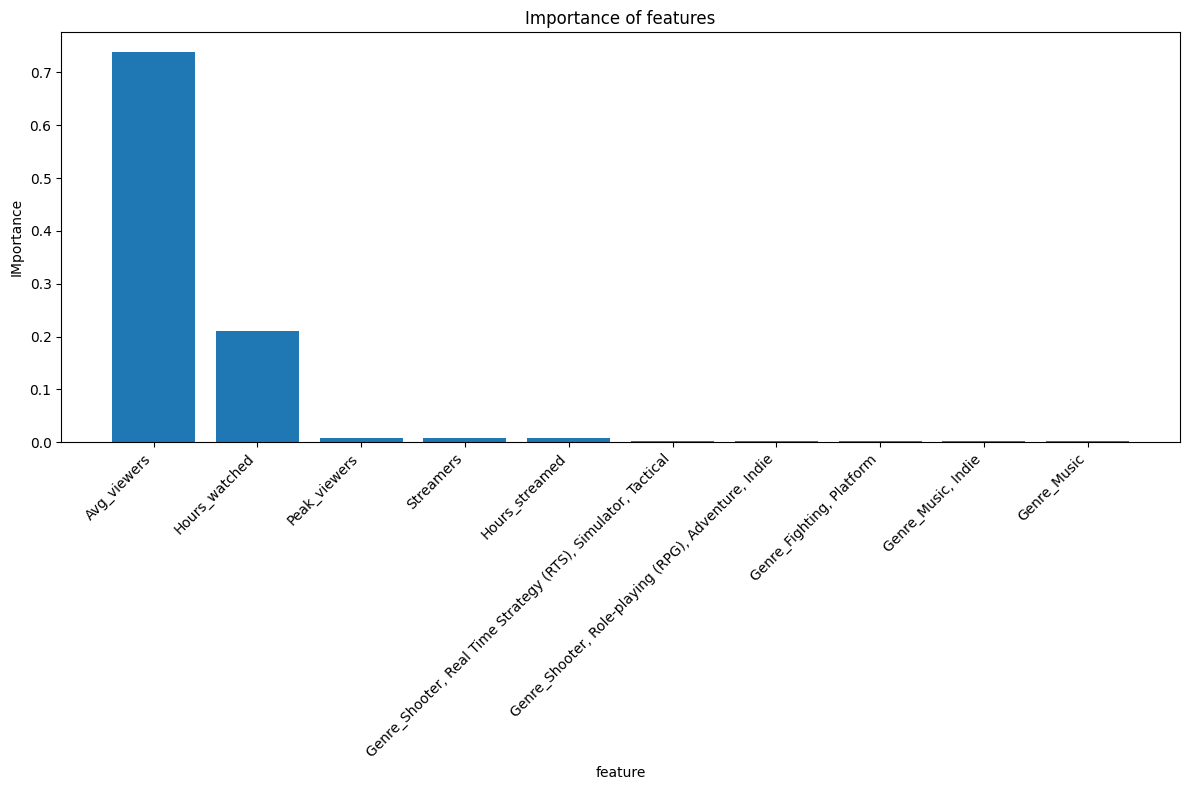

In [9]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Importance of features")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45, ha='right')
plt.xlabel('feature')
plt.ylabel('IMportance')
plt.tight_layout()
plt.show()


In [29]:
merged_df['Release Year'] = pd.to_numeric(merged_df['Release Year'], errors='coerce')
merged_df = merged_df.dropna(subset=['Release Year'])
merged_df['Release Year'] = merged_df['Release Year'].astype(int)
future_year = 2020
future_month = 5
if 'Month' in merged_df.columns:
    X_future = merged_df[(merged_df['Release Year'] == future_year) & (merged_df['Month'] == future_month)]
else:
    X_future = merged_df[merged_df['Release Year'] == future_year]  
X_future_games = X_future[['Game']].copy()  
X_future = X_future.drop(columns=['Rank', 'Game'], errors='ignore')
missing_cols = set(features) - set(X_future.columns)
for col in missing_cols:
    X_future[col] = 0  
X_future = X_future[features]
predictions = rf_regressor.predict(X_future)
X_future['Predicted_Rank'] = predictions
X_future['Game'] = X_future_games['Game'].values  

top_10_games = X_future.sort_values('Predicted_Rank').drop_duplicates(subset=['Game']).head(10)
top_50_games = X_future.sort_values('Predicted_Rank').drop_duplicates(subset=['Game']).head(50)
top_100_games = X_future.sort_values('Predicted_Rank').drop_duplicates(subset=['Game']).head(100)
top_200_games = X_future.sort_values('Predicted_Rank').drop_duplicates(subset=['Game']).head(200)
print(f"\n**Top 10 Games for {future_year}-{future_month}**")
print(top_10_games[['Game', 'Predicted_Rank']])

print(f"\n**Top 50 Games for {future_year}-{future_month}**")
print(top_50_games[['Game', 'Predicted_Rank']])

print(f"\n**Top 100 Games for {future_year}-{future_month}**")
print(top_100_games[['Game', 'Predicted_Rank']])

print(f"\n**Top 200 Games for {future_year}-{future_month}**")
print(top_200_games[['Game', 'Predicted_Rank']])



**Top 10 Games for 2020-5**
                                Game  Predicted_Rank
17600                  Just Chatting        1.002744
10401                       VALORANT        2.220714
12804          Call of Duty: Warzone        3.862983
5603                             IRL        6.351698
12811                        FIFA 21        9.845106
12823                 Genshin Impact       20.778580
3219                        Creative       22.959734
10423  Animal Crossing: New Horizons       25.513167
20035                     Trackmania       31.422094
10427             Minecraft Dungeons       31.852007

**Top 50 Games for 2020-5**
                                     Game  Predicted_Rank
17600                       Just Chatting        1.002744
10401                            VALORANT        2.220714
12804               Call of Duty: Warzone        3.862983
5603                                  IRL        6.351698
12811                             FIFA 21        9.845106
12823      